In [ ]:
# 1. Imports & Dataset Upload
# ===================================
from google.colab import files
uploaded = files.upload()  # Upload Shakespeare_data.csv

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from torch.utils.data import Dataset, DataLoader, random_split
import re
import random
import os


Saving Shakespeare_data.csv to Shakespeare_data.csv


In [ ]:
# 2. Preprocessing
# ===================================
df = pd.read_csv("Shakespeare_data.csv")
all_text = " ".join(df["PlayerLine"].dropna().tolist())
sentences = re.split(r'(?<=[.!?]) +', all_text)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

# Build vocabulary
special_tokens = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
all_words = set(word for sent in sentences for word in sent.split())
word2idx = {word: idx + len(special_tokens) for idx, word in enumerate(sorted(all_words))}
for i, token in enumerate(special_tokens):
    word2idx[token] = i
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)
max_len = 30

In [ ]:
# 3. Dataset (Next-Word Prediction Version)
# =========================================
class SentenceDataset(Dataset):
    def __init__(self, sentences, word2idx, max_len):
        self.data = []
        self.word2idx = word2idx
        self.max_len = max_len

        for sentence in sentences:
            words = sentence.strip().split()
            if len(words) < 2:
                continue
            input_seq = ['<SOS>'] + words[:max_len - 2]
            target_seq = words[:max_len - 2] + ['<EOS>']

            input_idx = [word2idx.get(w, word2idx['<UNK>']) for w in input_seq]
            target_idx = [word2idx.get(w, word2idx['<UNK>']) for w in target_seq]

            # Padding
            input_idx += [word2idx['<PAD>']] * (max_len - len(input_idx))
            target_idx += [word2idx['<PAD>']] * (max_len - len(target_idx))

            self.data.append((input_idx, target_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_idx, target_idx = self.data[idx]
        return torch.tensor(input_idx), torch.tensor(target_idx)

# Create Dataset + Dataloaders
dataset = SentenceDataset(sentences, word2idx, max_len)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# 4. Model (BiLSTM with Dropout)
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=256, num_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=word2idx['<PAD>'])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.dropout(output)
        logits = self.fc(output)
        return logits

# Initialize model
model = LSTMModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1: Train Loss = 4.6048, Val Loss = 3.0880
Validation loss improved, model saved.
Epoch 2: Train Loss = 2.3547, Val Loss = 2.0872
Validation loss improved, model saved.
Epoch 3: Train Loss = 1.3602, Val Loss = 1.6196
Validation loss improved, model saved.
Epoch 4: Train Loss = 0.7615, Val Loss = 1.4013
Validation loss improved, model saved.
Epoch 5: Train Loss = 0.3852, Val Loss = 1.2909
Validation loss improved, model saved.
Epoch 6: Train Loss = 0.1625, Val Loss = 1.2306
Validation loss improved, model saved.
Epoch 7: Train Loss = 0.0603, Val Loss = 1.1949
Validation loss improved, model saved.
Epoch 8: Train Loss = 0.0258, Val Loss = 1.1653
Validation loss improved, model saved.
Epoch 9: Train Loss = 0.0135, Val Loss = 1.1544
Validation loss improved, model saved.
Epoch 10: Train Loss = 0.0080, Val Loss = 1.1330
Validation loss improved, model saved.
Epoch 11: Train Loss = 0.0053, Val Loss = 1.1245
Validation loss improved, model saved.
Epoch 12: Train Loss = 0.0037, Val Loss =

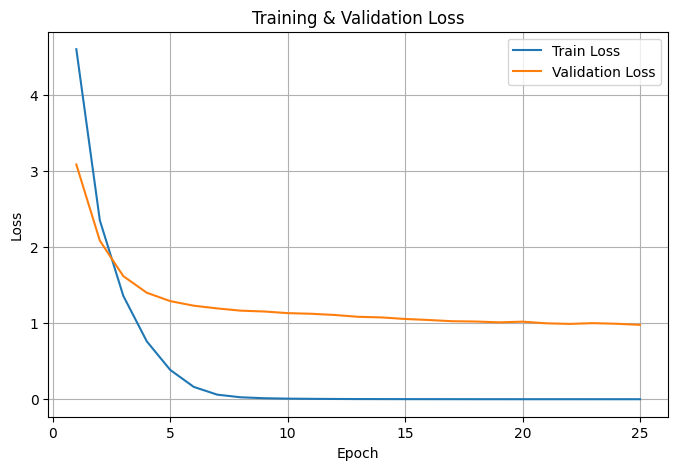

In [ ]:
import matplotlib.pyplot as plt

train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, patience_counter = 3, 0

for epoch in range(25):
    model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation loss improved, model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if patience_counter >= patience:
        print(" Early stopping!")
        break

# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=-1)
            mask = y != word2idx['<PAD>']
            correct += ((preds == y) & mask).sum().item()
            total += mask.sum().item()
    return correct / total

def evaluate_bleu(model, dataloader, device):
    model.eval()
    refs, hyps = [], []
    smooth = SmoothingFunction().method1
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(-1)
            for pred, target in zip(preds, y):
                hyp = [idx2word[i.item()] for i in pred if i.item() not in [word2idx['<PAD>'], word2idx['<SOS>']]]
                ref = [idx2word[i.item()] for i in target if i.item() not in [word2idx['<PAD>'], word2idx['<SOS>']]]
                hyps.append(hyp)
                refs.append([ref])
    bleu = corpus_bleu(refs, hyps, smoothing_function=smooth)
    return bleu

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Run evaluation
accuracy = evaluate_accuracy(model, val_loader, device)
bleu = evaluate_bleu(model, val_loader, device)

print(f"Word-level Accuracy: {accuracy:.4f}")
print(f"BLEU Score: {bleu:.4f}")


Word-level Accuracy: 0.9219
BLEU Score: 0.3481


In [ ]:
import torch
import torch.nn.functional as F
from collections import Counter

def nucleus_sampling_with_repetition_penalty(model, start_text, word2idx, idx2word, device,
                                             max_len=50, temperature=1.0, top_p=0.9,
                                             repetition_penalty=1.2, repetition_threshold=3):
    model.eval()
    tokens = [word2idx['<SOS>']] + [word2idx.get(w, word2idx['<UNK>']) for w in start_text.lower().split()]
    repetition_counter = Counter()

    for _ in range(max_len):
        input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(input_tensor)[0, -1] / temperature
            logits = logits.cpu()

            # Apply repetition penalty
            for token_id, count in repetition_counter.items():
                if count > 0 and token_id < logits.size(0):
                    logits[token_id] /= repetition_penalty ** count

            # Sort logits and calculate softmax cumulative probs for top-p
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            sorted_probs = F.softmax(sorted_logits, dim=0)
            cumulative_probs = torch.cumsum(sorted_probs, dim=0)

            # Remove tokens with cumulative prob above top_p
            sorted_indices_to_remove = cumulative_probs > top_p
            # Always keep at least one token
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = False

            # Set logits of removed tokens to -inf
            filtered_logits = sorted_logits.clone()
            filtered_logits[sorted_indices_to_remove] = -float('Inf')

            # Convert back to original ordering
            logits = torch.full_like(logits, -float('Inf'))
            logits[sorted_indices] = filtered_logits

            probs = F.softmax(logits, dim=0)

            # Sample next token
            next_token = torch.multinomial(probs, 1).item()

        # Update repetition counter
        repetition_counter[next_token] += 1
        if repetition_counter[next_token] > repetition_threshold:
            # Skip adding if token repeated too often, break if stuck
            break

        if next_token == word2idx['<EOS>']:
            break

        tokens.append(next_token)

        # Avoid infinite repetition of last token (5 repeats)
        if len(tokens) >= 6 and len(set(tokens[-5:])) == 1:
            break

    # Convert tokens to words, skipping special tokens
    words = [idx2word.get(t, '<UNK>') for t in tokens if t not in [word2idx['<SOS>'], word2idx['<EOS>'], word2idx['<PAD>']]]

    # Cleanup duplicates (remove direct repeats)
    cleaned_words = []
    for i, w in enumerate(words):
        if i > 0 and w == words[i-1]:
            continue
        cleaned_words.append(w)

    sentence = ' '.join(cleaned_words).strip()
    sentence = sentence.capitalize()
    if not sentence.endswith(('.', '!', '?')):
        sentence += '.'

    return sentence
start = input("Enter a starting sentence: ")
print("\nGenerated Text:\n", nucleus_sampling_with_repetition_penalty(
    model, start, word2idx, idx2word, device,
    max_len=70, temperature=0.9, top_p=0.9, repetition_penalty=1.3
))


Enter a starting sentence: The king and queen

Generated Text:
 The king and queen moult something: soldiership. battlements, felt, bleach high pyramides favours damned? yes, marchioness master puppy. am own many mermaids, vacancy, borne. their sudden foil gentlemen.


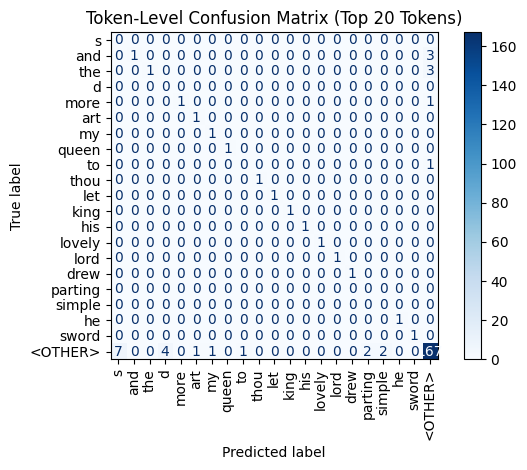

In [ ]:
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Simple tokenizer (word-level)
def simple_tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Flatten token-level predictions and references
all_refs = []
all_preds = []

for ref, gen in zip(reference_sentences, generated_sentences):
    ref_tokens = simple_tokenize(ref)
    gen_tokens = simple_tokenize(gen)

    # Pad to same length for alignment
    max_len = max(len(ref_tokens), len(gen_tokens))
    ref_tokens += ['<PAD>'] * (max_len - len(ref_tokens))
    gen_tokens += ['<PAD>'] * (max_len - len(gen_tokens))

    all_refs.extend(ref_tokens)
    all_preds.extend(gen_tokens)

# Build vocab and filter to top-N tokens for clarity
vocab = list(set(all_refs + all_preds))
if '<PAD>' in vocab:
    vocab.remove('<PAD>')
vocab = sorted(vocab, key=lambda w: all_refs.count(w) + all_preds.count(w), reverse=True)

top_n = 20
top_vocab = vocab[:top_n]
label_indices = {w: i for i, w in enumerate(top_vocab)}
labels = top_vocab + ['<OTHER>']

# Replace rare tokens with <OTHER>
filtered_refs = [w if w in label_indices else '<OTHER>' for w in all_refs]
filtered_preds = [w if w in label_indices else '<OTHER>' for w in all_preds]

# Compute confusion matrix
conf_mat = confusion_matrix(filtered_refs, filtered_preds, labels=labels)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Token-Level Confusion Matrix (Top 20 Tokens)")
plt.tight_layout()
plt.show()
